In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn import model_selection
from sklearn import metrics
from skopt import dump, load
from skopt.plots import plot_convergence
from scipy.stats import reciprocal
import skopt
from skopt import gp_minimize
import numpy as np
import pandas as pd
from sklearn import metrics
import datetime
import re
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Load Data from Sources

In [3]:
df = pd.read_excel('./etching.xlsx')

In [4]:
df.columns

Index(['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow',
       'O2 Flow', 'Etch Rate -Rp A/min', 'Etch Uniformity',
       'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph'],
      dtype='object')

In [5]:
df.shape

(53, 10)

# Data Pre-Processing

In [11]:
x_full_df = df[['Pressure', 'RF Power', 'Electrode Gap', 'CCL_4 Flow', 'HE Flow', 'O2 Flow']].astype(float)
y_full_df = df[['Etch Rate -Rp A/min', 'Etch Uniformity', 'Oxide Selectivity - Sox', 'Photoresist Selectivity - Sph']].astype(float)

In [12]:
x = x_full_df.to_numpy()
y = y_full_df.to_numpy()

In [13]:
x_scaler = MaxAbsScaler().fit(x)
y_scaler = MaxAbsScaler().fit(y)
x_full = x_scaler.transform(x)
y_full = y_scaler.transform(y)

In [14]:
y = np.array([ x[0] for x in y ])

In [15]:
x_scaler = MinMaxScaler().fit(x)
x_scaled = x_scaler.transform(x)

In [16]:
# Split last 25% of data for test data
split_val = int(x.shape[0] * .75)
x_train_full, x_test = x_scaled[:split_val], x_scaled[split_val:]
y_train_full, y_test = y[:split_val], y[split_val:]

# Simple Model Build

In [17]:
sm_model = MultiOutputRegressor(SVR())
sm_model.fit(x_full, y_full)

MultiOutputRegressor(estimator=SVR())

In [18]:
sm_predicted = sm_model.predict(x_full)
mean_squared_error(sm_predicted, y_full)

0.005909292119461543

# Impact of Initialization

In this section I will explore the effects of Kernel Functions, C values, and degree on the SVM's completetion time and average MSE

## Testing Kernels

In [19]:
def run_kernel_test():
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    test_results = []
    for k in kernels:
        test_mse = []
        test_time = []
        cv = KFold(25)
        for tr_i, ts_i in cv.split(x_full, y_full):
            x_tr, x_val = x_full[tr_i], x_full[ts_i]
            y_tr, y_val = y_full[tr_i], y_full[ts_i]
            test_model = MultiOutputRegressor(SVR(kernel=k))
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([k for x in range(10)], test_mse, test_time))
        print(f'{k} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [20]:
kernel_test_results = run_kernel_test()

linear :: 0.01599058216029009 0.002945547103881836
rbf :: 0.016830243394539833 0.0028387737274169923
poly :: 0.026219541837740987 0.04647672653198242
sigmoid :: 0.02388111392163951 0.0024567317962646486


### Build Graphs for this Section

In [21]:
temp = [ list(zip(x[0], x[1], x[2])) for x in kernel_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['kernel', 'mse', 'time'])

In [22]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5)

In [27]:
# kernel_mse_plot = sns.boxplot(x='kernel', y='mse', data=init_test_df)
# kernel_mse_plot.set(title='Effects on MSE from Kernel')
# kernel_mse_plot.figure.savefig('graphs/rie_kernel_mse.png')

In [30]:
# kernel_time_plot = sns.boxplot(x='kernel', y='time', data=init_test_df)
# kernel_time_plot.set(title='Effects on Time from Kernel')
# kernel_time_plot.figure.savefig('graphs/rie_kernel_time.png')

## Testing C

In [23]:
def run_c_test():
    cs = [.1, 1, 10, 100, 1000]
    test_results = []
    for c in cs:
        test_mse = []
        test_time = []
        cv = KFold(25)
        for tr_i, ts_i in cv.split(x_full, y_full):
            x_tr, x_val = x_full[tr_i], x_full[ts_i]
            y_tr, y_val = y_full[tr_i], y_full[ts_i]
            test_model = MultiOutputRegressor(SVR(C=c))
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([c for x in range(10)], test_mse, test_time))
        print(f'{c} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [24]:
c_test_results = run_c_test()

0.1 :: 0.016398763117512868 0.0030710506439208985
1 :: 0.016830243394539833 0.0026800155639648436
10 :: 0.018694532951027937 0.002679758071899414
100 :: 0.0186931817360974 0.0028707408905029297
1000 :: 0.018693922644202533 0.003558511734008789


### Building Graphs

In [25]:
temp = [ list(zip(x[0], x[1], x[2])) for x in c_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['c', 'mse', 'time'])

In [41]:
# c_mse_plot = sns.boxplot(x='c', y='mse', data=init_test_df)
# c_mse_plot.set(title='Effects on MSE from C')
# c_mse_plot.figure.savefig('graphs/rie_c_mse.png')

In [27]:
# c_mse_plot = sns.boxplot(x='c', y='time', data=init_test_df)
# c_mse_plot.set(title='Effects on Time from C')
# c_mse_plot.figure.savefig('graphs/rie_c_time.png')

## Testing Degree

In [28]:
def run_degree_test():
    cs = [2, 3, 4, 5, 6]
    test_results = []
    for c in cs:
        test_mse = []
        test_time = []
        cv = KFold(10)
        for tr_i, ts_i in cv.split(x_full, y_full):
            x_tr, x_val = x_full[tr_i], x_full[ts_i]
            y_tr, y_val = y_full[tr_i], y_full[ts_i]
            test_model = MultiOutputRegressor(SVR(degree=c, kernel='poly'))
            start = time.time()
            test_model.fit(x_tr, y_tr)
            end = time.time()
            
            test_mse.append(mean_squared_error(y_val, test_model.predict(x_val)))
            test_time.append(end - start)
            
        avg_test_mse, avg_test_time = np.mean(test_mse), np.mean(test_time)
        test_results.append(([c for x in range(10)], test_mse, test_time))
        print(f'{c} :: {avg_test_mse} {avg_test_time}')
    return test_results

In [29]:
degree_test_results = run_degree_test()

2 :: 0.014199499078812567 0.00905160903930664
3 :: 0.03156561620680872 0.04340729713439941
4 :: 0.058051884923513083 0.22323141098022461
5 :: 0.05837193439190027 0.10412049293518066
6 :: 0.06237992044822125 0.06386365890502929


In [30]:
temp = [ list(zip(x[0], x[1], x[2])) for x in degree_test_results ]
init_test_data = []
for i in temp:
    for j in i:
        init_test_data.append(j)
init_test_df = pd.DataFrame(data=init_test_data, columns=['degree', 'mse', 'time'])

In [31]:
# deg_mse_plot = sns.boxplot(x='degree', y='mse', data=init_test_df)
# deg_mse_plot.set(title='Effects on MSE from Degree of Polynomial')
# deg_mse_plot.figure.savefig('graphs/rie_deg_mse.png')

In [34]:
# deg_mse_plot = sns.boxplot(x='degree', y='time', data=init_test_df)
# deg_mse_plot.set(title='Effects on Time from Degree of Polynomial')
# deg_mse_plot.figure.savefig('graphs/rie_deg_time.png')

# Hyper-Parameter Tuning

In [53]:
SPACE = [
    skopt.space.Categorical(['rbf', 'sigmoid', 'poly'], name='kernel'),
    skopt.space.Categorical([2, 3, 4], name='degree'),
    skopt.space.Real(1e-1, 1e3, prior='log-uniform', name='C'),
    skopt.space.Real(1e-2, 4, prior='log-uniform', name='epsilon')
]

In [56]:
@skopt.utils.use_named_args(SPACE)
def objective(**params):
    mse_scores = []
    
    cv = LeaveOneOut()
    for train_idx, val_idx in cv.split(x_full, y_full):
        x_tr, x_val, = x_full[train_idx], x_full[val_idx]
        y_tr, y_val = y_full[train_idx], y_full[val_idx]
        
        model = MultiOutputRegressor(SVR(
            kernel=params['kernel'],
            degree=params['degree'], # only used with poly kernel
            C=params['C'],
            epsilon=params['epsilon']
        ))
        
        model.fit(x_tr, y_tr)
        trial_score = mean_squared_error(y_val, model.predict(x_val))
        mse_scores.append(trial_score)
    print(f'Avg Validation MSE: {np.mean(mse_scores)}')
    return np.mean(mse_scores)

In [63]:
opt_results = gp_minimize(objective, SPACE, n_calls=10, random_state=2)

Avg Validation MSE: 0.020797176476729812
Avg Validation MSE: 0.021068441828763863
Avg Validation MSE: 0.05316612402883089
Avg Validation MSE: 0.019548004517721266
Avg Validation MSE: 0.05316612402883089
Avg Validation MSE: 0.013665698125326737
Avg Validation MSE: 0.05316612402883089
Avg Validation MSE: 0.02169298861835189
Avg Validation MSE: 0.04445293096694469
Avg Validation MSE: 0.05316612402883089


In [64]:
dump(opt_results, 'tuning/opt_results.pkl')

In [65]:
opt_loaded = load('tuning/opt_results.pkl')

In [66]:
print(f"""
    Best Avg. Val MSE: {opt_loaded.fun:.4f}
    Best Parameters:
    - Kernel: {opt_loaded.x[0]}
    - Degree: {opt_loaded.x[1]}
    - C: {opt_loaded.x[2]}
    - Epsilon: {opt_loaded.x[3]}
    
""")


    Best Avg. Val MSE: 0.0137
    Best Parameters:
    - Kernel: rbf
    - Degree: 3
    - C: 0.2915904327209439
    - Epsilon: 0.029707400715588302
    



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

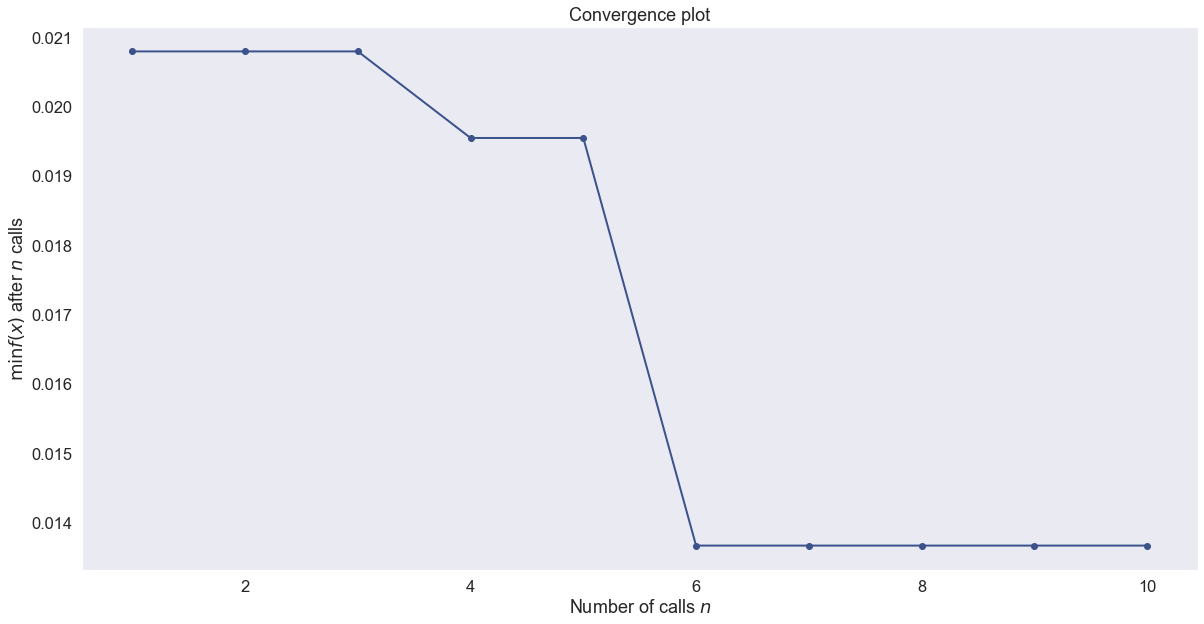

In [67]:
plot_convergence(opt_loaded)

# Model Performance & Evaluation

In [68]:
opt_loaded.x

['rbf', 3, 0.2915904327209439, 0.029707400715588302]

In [69]:
regressor = MultiOutputRegressor(SVR(
    kernel='poly',
    degree=2,
    C=1.9795388574374426,
    epsilon=0.02451675480274238
))

In [70]:
regressor.fit(x_full, y_full)

MultiOutputRegressor(estimator=SVR(C=1.9795388574374426, degree=2,
                                   epsilon=0.02451675480274238, kernel='poly'))

In [72]:
predictions = regressor.predict(x_full)

In [73]:
mean_squared_error(predictions, y_full)

0.006225448163869978

In [75]:
r2_score(y_full, predictions)

0.7688026534721795

In [77]:
errors = y_full - predictions

[Text(0.5, 0, 'Error'), Text(0.5, 1.0, 'Binned Error Counts')]

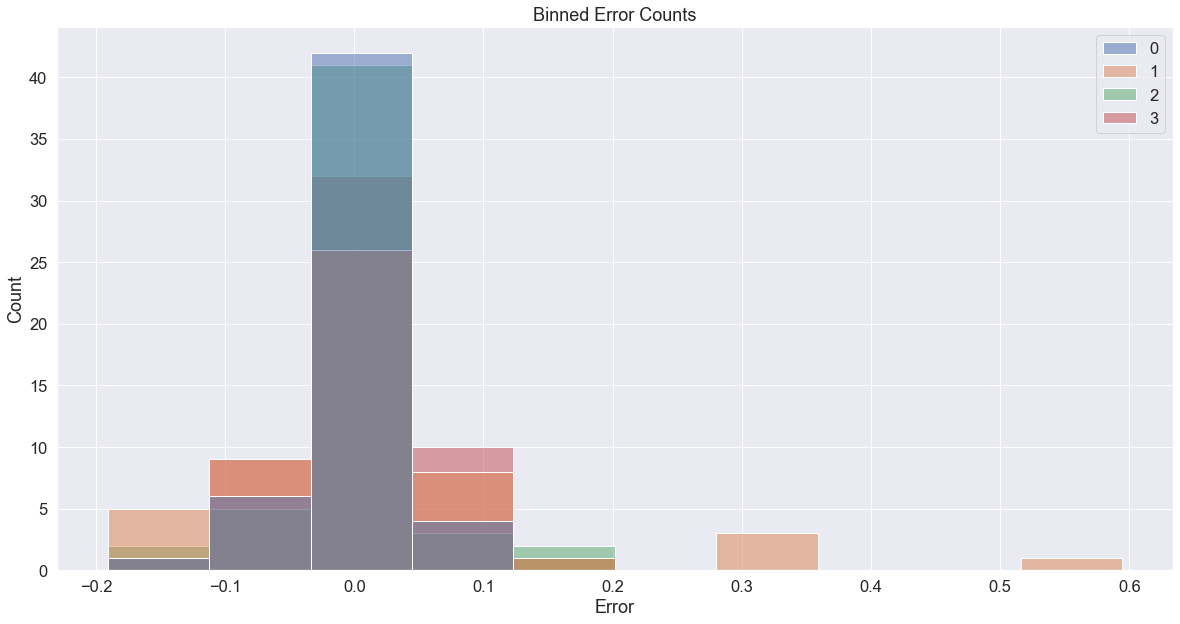

In [78]:
ax = sns.histplot(data=errors, bins=10)
ax.set(xlabel='Error', title='Binned Error Counts')

In [80]:
y_test_etch_rate = [ x[0] for x in y_full ] 
predictions_etch_rate = np.array([ x[0] for x in predictions ])
y_test_etch_uni = [ x[1] for x in y_full ] 
predictions_etch_uni = np.array([ x[1] for x in predictions ])
y_test_ox_sel = [ x[2] for x in y_full ] 
predictions_ox_sel = np.array([ x[2] for x in predictions ])
y_test_pho_sel = [ x[3] for x in y_full ] 
predictions_pho_sel = np.array([ x[3] for x in predictions ])

## $R^2$ Scores

In [81]:
print(f'''
    Etch Rate: {r2_score(y_test_etch_rate, predictions_etch_rate)}
    Etch Uni.: {r2_score(y_test_etch_uni, predictions_etch_uni)}
    Ox. Sel. : {r2_score(y_test_ox_sel, predictions_ox_sel)}
    Photo Sel: {r2_score(y_test_pho_sel, predictions_pho_sel)}
''')


    Etch Rate: 0.8512406545469282
    Etch Uni.: 0.5379127123979552
    Ox. Sel. : 0.8568530995242718
    Photo Sel: 0.8292041474195624



In [87]:
sns.set(rc={'figure.figsize':(10,7)}, font_scale=1.5)

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Etch Rate')]

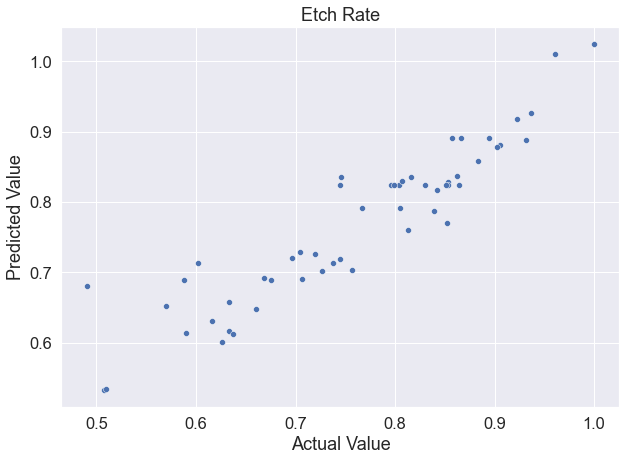

In [90]:
ax = sns.scatterplot(x=y_test_etch_rate, y=predictions_etch_rate)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Etch Rate')
# plt.savefig('graphs/rie_ap_etch_rate.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Etch Uniformity')]

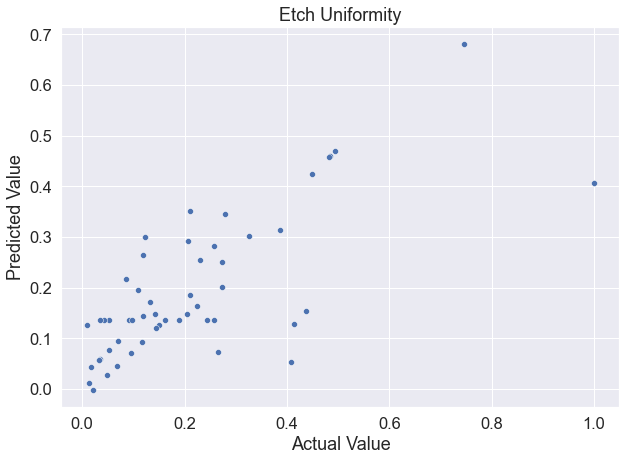

In [93]:
ax = sns.scatterplot(x=y_test_etch_uni, y=predictions_etch_uni)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Etch Uniformity')
# plt.savefig('rie_ap_etch_uni.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Oxide Selectivity')]

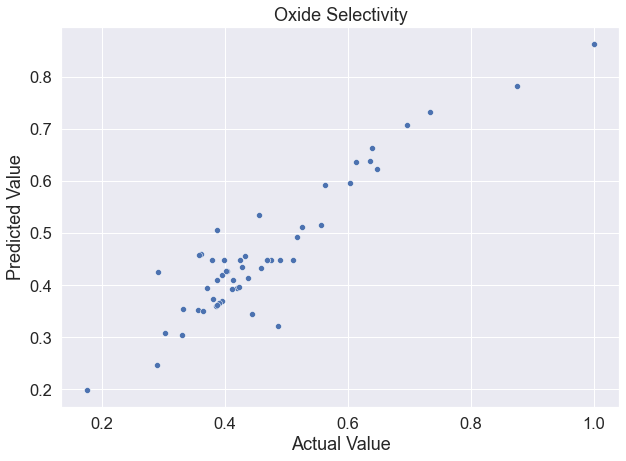

In [96]:
ax = sns.scatterplot(x=y_test_ox_sel, y=predictions_ox_sel)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Oxide Selectivity')
# plt.savefig('rie_ap_ox_sel.png')

[Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value'),
 Text(0.5, 1.0, 'Photoresist Selectivity')]

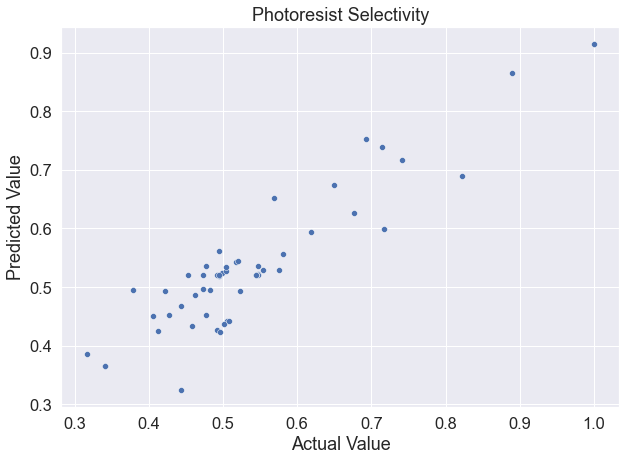

In [99]:
ax = sns.scatterplot(x=y_test_pho_sel, y=predictions_pho_sel)
ax.set(xlabel='Actual Value', ylabel='Predicted Value', title='Photoresist Selectivity')
# plt.savefig('rie_ap_photo_sel.png')